mock sensor data, mock processed data
mock historical data (1 year)  
mock live data (from the last day in db to now + ongoing data)  


seat availability  
crowd density  
temperature  





## crowd density and seat availability
#### capacity constraints:  
0 <= total passenger count < carriage capacity  
during peak hour - occupancy rate - 70-100%
off peak - occupancy rate - 0 - 70%

#### time constraint:  
train operating hours - 530-0015

#### patterns:  
peak hours weekdays - 7am - 930am, 530pm - 830pm  
peak hours weekend - 8am - 9am, 630pm-830pm  
peak hour train frequency (len of interval) - 2-3 minutes  
off peak train frequency (len of interval) - 5-8 minutes  

#### noise - breakdowns, service/ maintenance time (<= 5%)
peak period noise - low
non-peak noise - high


## temperature
use monthly average data
take into account rain/ sun, day/ night
take into account airconditioning


simulate for one carriage, 7 days since today first

In [37]:
import pandas as pd

hist_temp = pd.read_csv("../../historical-daily-weather-records.csv")
# hist_temp = hist_temp.tail(365)
# hist_temp.dropna(subset=["mean_temperature"], inplace=True)
hist_temp = hist_temp[hist_temp.mean_temperature != "na"]
hist_temp.mean_temperature = hist_temp.mean_temperature.astype(float)
hist_temp
# max(hist_temp.mean_temperature)
# hist_temp = hist_temp[["date", "mean_temperature"]]


,date,station,daily_rainfall_total,highest_30_min_rainfall,highest_60_min_rainfall,highest_120_min_rainfall,mean_temperature,maximum_temperature,minimum_temperature,mean_wind_speed,max_wind_speed
23,2009-01-24,Admiralty,0,na,na,na,26.8,31.4,24.4,11.7,38.2
24,2009-01-25,Admiralty,0.8,na,na,na,25.9,27.8,24.4,12.7,38.2
25,2009-01-26,Admiralty,0,na,na,na,25.9,29.6,23.7,12.4,42.5
27,2009-01-28,Admiralty,0,na,na,na,26.6,31.9,23.7,10.3,32.4
28,2009-01-29,Admiralty,0,na,na,na,26.3,30,23.9,11.3,33.5
...,...,...,...,...,...,...,...,...,...,...,...
2843,2017-11-15,Admiralty,0,0,0,0,26.9,31.6,24.8,6.8,29.5
2844,2017-11-16,Admiralty,16.2,14.4,16.2,16.2,27.8,33,25,6.5,31.3
2845,2017-11-17,Admiralty,0.2,0.2,0.2,0.2,27.5,31.7,24.2,6.5,44.3
2846,2017-11-18,Admiralty,58,47.8,55.6,56.4,27.6,34.5,23.2,5,40.3


count    2720.000000
mean       27.632059
std         1.186947
min        23.300000
25%        26.800000
50%        27.600000
75%        28.500000
max        30.800000
Name: mean_temperature, dtype: float64

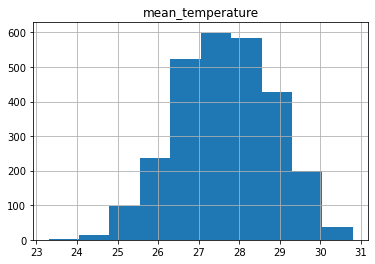

In [39]:
hist_temp.hist("mean_temperature")

hist_temp.mean_temperature.describe()

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

def plot_time_series(time, values, label):
    plt.figure(figsize=(10,6))
    plt.plot(time, values)
    plt.xlabel("Time", fontsize=20)
    plt.ylabel("Value", fontsize=20)
    plt.title(label, fontsize=20)
    plt.grid(True)

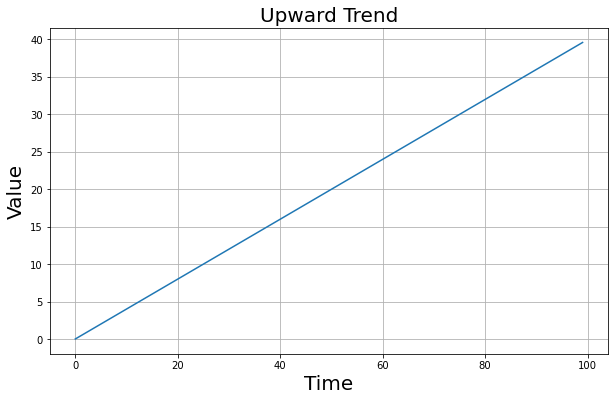

In [3]:
time = np.arange(100)
values = time*0.4
plot_time_series(time, values, "Upward Trend")

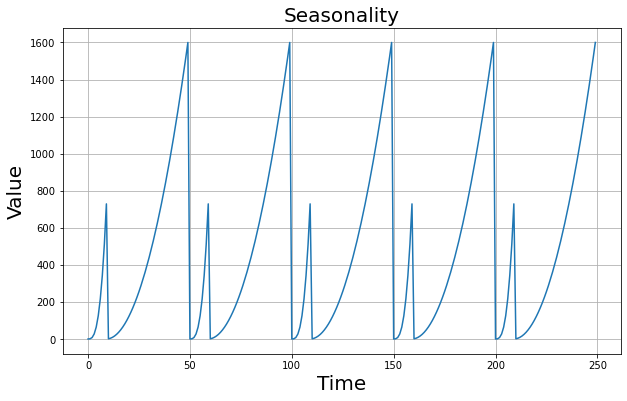

In [4]:
# Just a random pattern
time = np.arange(50)
values = np.where(time < 10, time**3, (time-9)**2)
# Repeat the pattern 5 times
seasonal = []
for i in range(5):
    for j in range(50):
        seasonal.append(values[j])
# Plot
time_seasonal = np.arange(250)
plot_time_series(time_seasonal, seasonal, label="Seasonality")

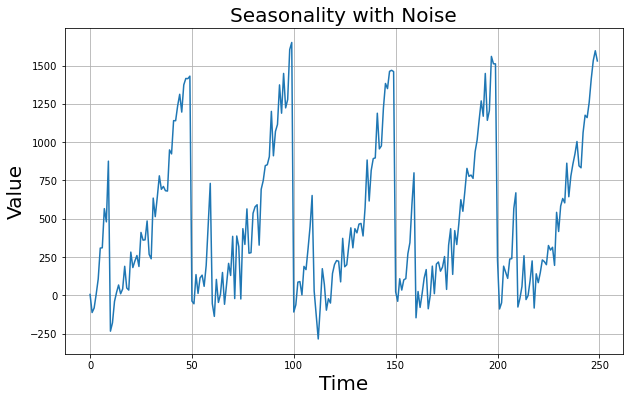

In [5]:
noise = np.random.randn(250)*100
seasonal += noise
time_seasonal = np.arange(250)
plot_time_series(time_seasonal, seasonal, label="Seasonality with Noise")

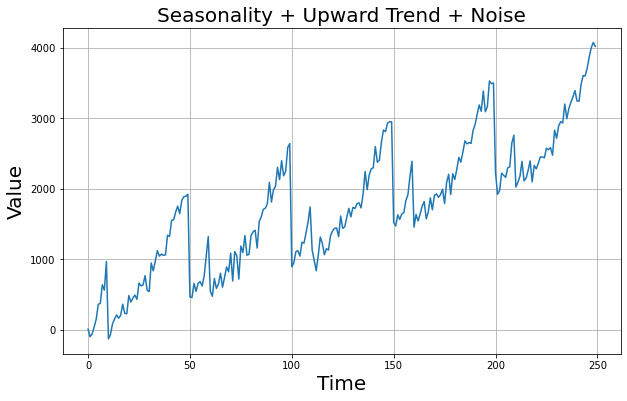

In [6]:
seasonal_upward = seasonal + np.arange(250)*10
time_seasonal = np.arange(250)
plot_time_series(time_seasonal, seasonal_upward, label="Seasonality + Upward Trend + Noise")

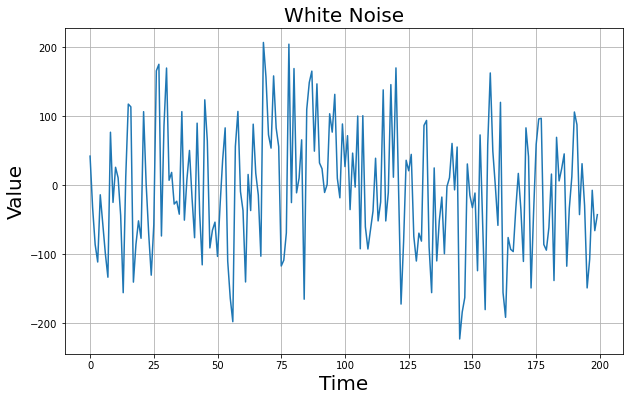

In [7]:
time = np.arange(200)
values = np.random.randn(200)*100
plot_time_series(time, values, label="White Noise")

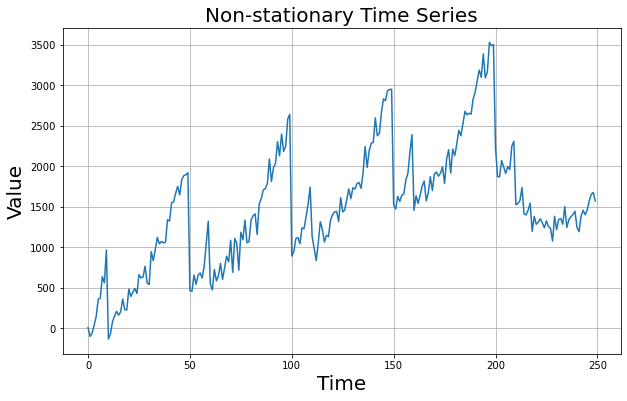

In [8]:
big_event = np.zeros(250)
big_event[-50:] = np.arange(50)*-50
non_stationary = seasonal_upward + big_event
time_seasonal = np.arange(250)
plot_time_series(time_seasonal, non_stationary, label="Non-stationary Time Series")

In [ ]:
ENTRY_COUNT = 7

simulate timestamp

In [2]:
from random import randrange
import datetime


def random_date(start, l):
    current = start
    while l >= 0:
        current = current + datetime.timedelta(minutes=randrange(10))
        yield current
        l -= 1


startDate = datetime.datetime(2022, 9, 20, 13, 00)


for x in (list(random_date(startDate, 10))):
    print(x.strftime("%d/%m/%y %H:%M"))


20/09/22 13:08
20/09/22 13:11
20/09/22 13:15
20/09/22 13:24
20/09/22 13:28
20/09/22 13:36
20/09/22 13:45
20/09/22 13:49
20/09/22 13:51
20/09/22 13:54
20/09/22 13:55


# START

In [229]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import random
import datetime

daily_temp = pd.read_csv("../data/test/daily_temperature.csv")
passenger_congestion_weekday = pd.read_csv("../data/test/passenger_congestion_rate_weekday.csv")
passenger_congestion_weekend = pd.read_csv("../data/test/passenger_congestion_rate_weekend.csv")
passenger_congestion_weekend

,time,value
0,0.052114,17.300323
1,0.079543,16.001621
2,0.106971,15.352271
3,0.134400,14.702920
4,0.161828,14.378245
...,...,...
548,23.887543,16.001621
549,23.914971,15.352271
550,23.942400,15.352271
551,23.969828,14.702920


In [230]:
# passenger_congestion_weekend.value = passenger_congestion_weekend.value + 18
# passenger_congestion_weekend.to_csv("../data/test/passenger_congestion_rate_weekend.csv", index=False)

## Congestion

In [231]:
def convert_float_to_time(time_float):
    hour = math.floor(time_float)
    minute = 60 * (time_float - hour)
    return datetime.time(int(hour), int(minute))


def convert_float_to_seconds(time_float):
    hour = math.floor(time_float)
    minute = 60 * (time_float - hour)
    return hour * 60 * 60 + minute * 60



passenger_congestion_weekday["time"] = passenger_congestion_weekday["time"].apply(convert_float_to_seconds)
passenger_congestion_weekend["time"] = passenger_congestion_weekend["time"].apply(convert_float_to_seconds)
passenger_congestion_weekday

,time,value
0,88.867969,9.586037
1,187.610826,8.612011
2,286.353683,8.287336
3,385.096540,6.663959
4,483.839397,5.365258
...,...,...
639,85797.667969,11.534089
640,85896.410826,10.884738
641,85995.153683,10.560063
642,86192.639397,9.910712


In [232]:
INTERVAL_MINUTES = 3
seconds_bin = [sec for sec in range(0, 24*60*60, INTERVAL_MINUTES*60)]

passenger_congestion_weekday["time_bin"] = np.digitize(passenger_congestion_weekday["time"], seconds_bin)
passenger_congestion_weekend["time_bin"] = np.digitize(passenger_congestion_weekend["time"], seconds_bin)
passenger_congestion_weekday

,time,value,time_bin
0,88.867969,9.586037,1
1,187.610826,8.612011,2
2,286.353683,8.287336,2
3,385.096540,6.663959,3
4,483.839397,5.365258,3
...,...,...,...
639,85797.667969,11.534089,477
640,85896.410826,10.884738,478
641,85995.153683,10.560063,478
642,86192.639397,9.910712,479


In [233]:
congestion_weekday_seeder = passenger_congestion_weekday.groupby("time_bin").mean().reset_index()
congestion_weekday_seeder["time_bin_s"] = congestion_weekday_seeder["time_bin"] * INTERVAL_MINUTES * 60
congestion_weekday_seeder.drop(columns=["time", "time_bin"], inplace=True)
congestion_weekday_seeder.rename(columns={"value":"rate"}, inplace=True)
congestion_weekday_seeder = congestion_weekday_seeder[["time_bin_s", "rate"]]

congestion_weekend_seeder = passenger_congestion_weekend.groupby("time_bin").mean().reset_index()
congestion_weekend_seeder["time_bin_s"] = congestion_weekend_seeder["time_bin"] * INTERVAL_MINUTES * 60
congestion_weekend_seeder.drop(columns=["time", "time_bin"], inplace=True)
congestion_weekend_seeder.rename(columns={"value":"rate"}, inplace=True)
congestion_weekend_seeder = congestion_weekend_seeder[["time_bin_s", "rate"]]

congestion_weekend_seeder


,time_bin_s,rate
0,360,16.650972
1,540,15.027595
2,720,13.891232
3,900,10.806816
4,1080,8.534089
...,...,...
330,85680,18.274349
331,85860,17.137985
332,86040,16.326297
333,86220,15.352271


In [234]:
def generate_random_times_in_day():
    START = 0
    END = 1 * 60 * 60 * 24
    K = int(86400 / 300)
    time_in_s = random.sample(range(START, END), K)
    return sorted(set(time_in_s))

# random_times = generate_random_times_in_day()

In [235]:
WD_NON_PEAK_VARIATION = 0.15
WD_PEAK_VARIATION = 0.05
WE_NON_PEAK_VARIATION = 0.25
WE_PEAK_VARIATION = 0.1
# peak period weekdays: 7am - 930am, 530-830pm
WD_PEAK_1_START = 7 * 60 * 60
WD_PEAK_1_END = 9.5 * 60 * 60 
WD_PEAK_2_START = 17.5 * 60 * 60
WD_PEAK_2_END = 20.5 * 60 * 60
# peak period weekend: 8am - 930am, 630-830pm
WE_PEAK_1_START = 8 * 60 * 60
WE_PEAK_1_END = 9.5 * 60 * 60
WE_PEAK_2_START = 18.5 * 60 * 60 
WE_PEAK_2_END = 20.5 * 60 * 60
CLOSING_TIME = 0.25 * 60 * 60
OPENING_TIME = 5.5 * 60 * 60

def generate_random_value(time_in_day_s: int, is_weekday: bool, seed_value: float):
    if is_weekday:
        if WD_PEAK_1_START <= time_in_day_s <= WD_PEAK_1_END or WD_PEAK_2_START <= time_in_day_s <= WD_PEAK_2_END:
            upper_bound = seed_value * (1 + WD_PEAK_VARIATION)
            lower_bound = seed_value * (1 - WD_PEAK_VARIATION)
        else:
            upper_bound = seed_value * (1 + WD_NON_PEAK_VARIATION)
            lower_bound = seed_value * (1 - WD_NON_PEAK_VARIATION)
    else:
        if WE_PEAK_1_START <= time_in_day_s <= WE_PEAK_1_END or WE_PEAK_2_START <= time_in_day_s <= WE_PEAK_2_END:
            upper_bound = seed_value * (1 + WE_PEAK_VARIATION)
            lower_bound = seed_value * (1 - WE_PEAK_VARIATION)
        else:
            upper_bound = seed_value * (1 + WE_NON_PEAK_VARIATION)
            lower_bound = seed_value * (1 - WE_NON_PEAK_VARIATION)

    if upper_bound > 100: upper_bound = 100
    if lower_bound > 100: lower_bound = 100
    if upper_bound < 0: upper_bound = 0
    if lower_bound < 0: lower_bound = 0

    return random.uniform(lower_bound, upper_bound)


def get_seed_value_from_time(seed_value_df, time_in_day_s):
    if 0 <= time_in_day_s <= CLOSING_TIME or OPENING_TIME <= time_in_day_s <= 23.999 * 60 * 60:
        result_index = seed_value_df['time_bin_s'].sub(time_in_day_s).abs().idxmin()
        return seed_value_df.rate[result_index]
    else: return 0


def generate_random_values_daily(seed_df, times_in_s, is_weekday):
    random_vals = []
    for time_in_s in times_in_s:
        base_val = get_seed_value_from_time(seed_df, time_in_s)
        random_val = generate_random_value(time_in_s, is_weekday, base_val)
        random_vals.append(random_val)
    return random_vals



In [236]:
# random_vals = generate_random_values_daily(congestion_weekday_seeder, random_times, is_weekday=False)

# daily_congestion_df = pd.DataFrame({"time": random_times, "value": random_vals})
# daily_congestion_df.time = daily_congestion_df.time + 1666281600
# daily_congestion_df


In [237]:
START_DATE = int(datetime.datetime(2022, 10, 21).timestamp())
today = datetime.datetime.today()
END_DATE = int(datetime.datetime(today.year, today.month, today.day).timestamp())

def generate_historical_congestion_data(weekday_data_seeder, weekend_data_seeder):
    full_df = pd.DataFrame()

    for day in range(START_DATE, END_DATE, 86400):
        random_times = generate_random_times_in_day()
        is_weekday = datetime.datetime.fromtimestamp(day).weekday() in [i for i in range(5)]
        if is_weekday:
            random_vals = generate_random_values_daily(weekday_data_seeder, random_times, is_weekday)
        else:
            random_vals = generate_random_values_daily(weekend_data_seeder, random_times, is_weekday)
            
        daily_congestion_df = pd.DataFrame({"time": random_times, "value": random_vals})
        daily_congestion_df.time = daily_congestion_df.time + day
        full_df = pd.concat([full_df, daily_congestion_df], axis=0)
    return full_df

full_df = generate_historical_congestion_data(congestion_weekday_seeder, congestion_weekend_seeder)

In [238]:
def convert_epoch_to_datetime(epoch_time: int):
    return datetime.datetime.fromtimestamp(epoch_time).strftime('%Y-%m-%d %H:%M:%S')

full_df.time = full_df.time.apply(convert_epoch_to_datetime)
full_df

,time,value
0,2022-10-21 00:02:52,10.953778
1,2022-10-21 00:14:44,0.684498
2,2022-10-21 00:15:43,0.000000
3,2022-10-21 00:19:22,0.000000
4,2022-10-21 00:21:46,0.000000
...,...,...
283,2022-10-26 23:44:48,13.964987
284,2022-10-26 23:48:57,12.736635
285,2022-10-26 23:51:01,11.636693
286,2022-10-26 23:51:59,10.403746


## Temperature

In [239]:
HOT_MONTHS = [1,2,3,7,8]
COLD_MONTHS = [11,12]




## Graph

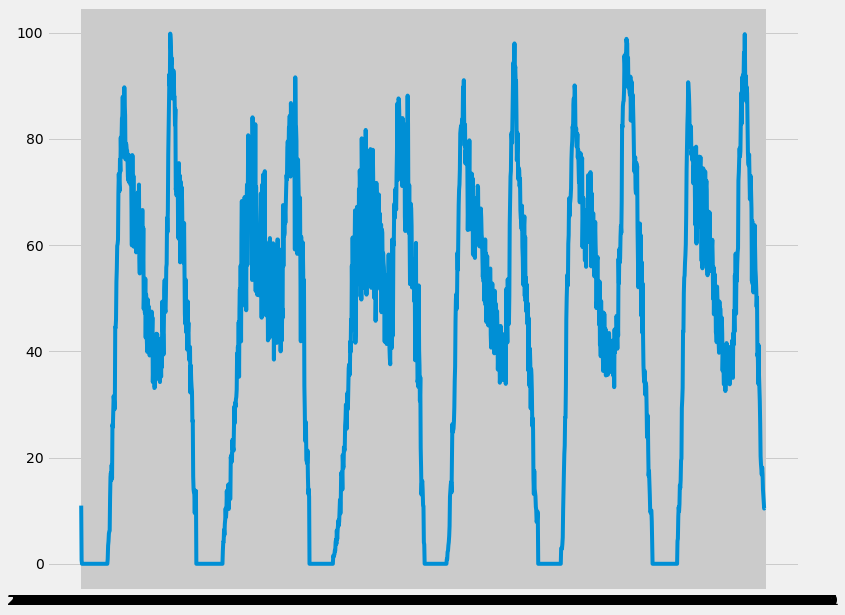

In [240]:
import matplotlib
from datetime import datetime

def plot_graph(df):
    # plt.style.use("fivethirtyeight")
 
    plt.figure(figsize=(12, 10))
    # df["time"] = df["time"].astype("datetime64[ns]")
    # df.time = pd.to_datetime(df.time)
    # x = [datetime.time(0,0,0), datetime.time(23,59,59)]
    # x_dt = [datetime.datetime.combine(datetime.date.today(), t) for t in x]
    # df['time'] = df['time'].apply(pd.Timestamp.timestamp)


    # df.plot()
    plt.plot(df.time, df.value)

plot_graph(full_df)

In [94]:

from datetime import datetime, time, timedelta
from random import randrange


PROMPT = 'Please enter a {} time in ISO format: '


def read_time(prompt: str) -> time:
    """Reads a time object from the user."""

    return time.fromisoformat(input(prompt))


def rand_datetime(start: datetime, end: datetime) -> datetime:
    """Returns a random datetime between start and end."""

    return datetime.fromtimestamp(randrange(round(start.timestamp()), round(end.timestamp())))


def rand_time(start: time, end: time) -> time:
    """Returns a random time between start and end."""

    return rand_datetime(
        datetime.combine(dt0 := datetime.fromtimestamp(0), start),
        datetime.combine(dt0 if start < end else dt0 + timedelta(days=1), end)).time()


def main():
    """Runs the script."""

    start = read_time(PROMPT.format('first'))
    end = read_time(PROMPT.format('second'))
    rand = rand_time(start, end)
    print('Your random time:', rand)


if __name__ == '__main__':
    main()

KeyboardInterrupt: Interrupted by user

In [ ]:
# Python3 code to demonstrate working of
# Random K dates in Range
# Using randrange() + timedelta() + loop
from datetime import date, timedelta
import random

# initializing dates ranges
test_date1, test_date2 = date(2021, 10, 1), datetime.today().date()

# printing dates
print("The original range : " + str(test_date1) + " " + str(test_date2))

# initializing K
K = 7

# getting days between dates
dates_bet = test_date2 - test_date1
total_days = dates_bet.days

res = []
for idx in range(K):
	random.seed(a=None)
	
	# getting random days
	randay = random.randrange(total_days)
	
	# getting random dates
	res.append(test_date1 + timedelta(days=randay))

# printing
print("K random dates in range : " + str(res))


In [45]:
from datetime import date


datetime.date(2021, 10, 1)